# Project: Analysis of Drug-Drug Interaction Networks
## Introduction
**Dataset Overview** 

This project focuses on analyzing a drug-drug interaction network, which represents interactions between drugs approved by the U.S. Food and Drug Administration (FDA). The network is structured as follows:

- Nodes: Represent drugs.
- Edges: Represent interactions between drugs.

Drug-drug interactions occur when the pharmacological effect of one drug is altered by the action of another drug. This can lead to unpredictable clinical effects, such as adverse drug reactions. When multiple drugs are administered together, the likelihood of adverse reactions increases, as one drug may enhance or diminish the effect of another. Identifying these interactions is crucial, especially during drug development, where it is essential to understand how a new candidate drug interacts with existing drugs on the market.

**Dataset Statistics**

- Nodes: 1,514 (drugs)
- Edges: 48,514 (interactions)
- Average Clustering Coefficient: 0.304
- Number of Triangles: 5,457,046
- Diameter: 7 (longest shortest path)
- 90-percentile Effective Diameter: 2.98

The dataset is highly connected, with almost all nodes (99.9%) belonging to the largest strongly connected component (SCC). This indicates a dense and interconnected network, making it an ideal candidate for graph analysis techniques.

---

### Objectives
The primary objectives of this project are:

- Centrality Analysis: Identify the most influential drugs in the network using various centrality measures.
- Community Detection: Uncover groups of drugs that interact strongly with each other using multiple community detection algorithms.
- Embedding Comparison: Compare spectral approaches and Node2Vec for generating node embeddings, evaluating their effectiveness in capturing the network's structure.
- Visualization: Provide clear and interpretable visualizations of the network, communities, and embeddings.



##  Import libraries

In [23]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import community as community_louvain  # Louvain algorithm
from networkx.algorithms.community import label_propagation_communities
from networkx.algorithms.community import asyn_lpa_communities
import itertools
from collections import defaultdict
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import linkage, fcluster

# Import data

In [3]:
# Load the dataset
file_path = 'data/ChCh-Miner_durgbank-chem-chem.tsv.gz'
df = pd.read_csv(file_path, sep='\t', compression='gzip', header=None, names=['Drug1', 'Drug2'])
df

,Drug1,Drug2
0,DB00862,DB00966
1,DB00575,DB00806
2,DB01242,DB08893
3,DB01151,DB08883
4,DB01235,DB01275
...,...,...
48509,DB00542,DB01354
48510,DB00476,DB01239
48511,DB00621,DB01120
48512,DB00808,DB01356


In [4]:
# Create a graph from the dataframe
G = nx.from_pandas_edgelist(df, 'Drug1', 'Drug2')

# Basic information about the graph
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Is the graph connected?", nx.is_connected(G))

Number of nodes: 1514
Number of edges: 48514
Is the graph connected? False


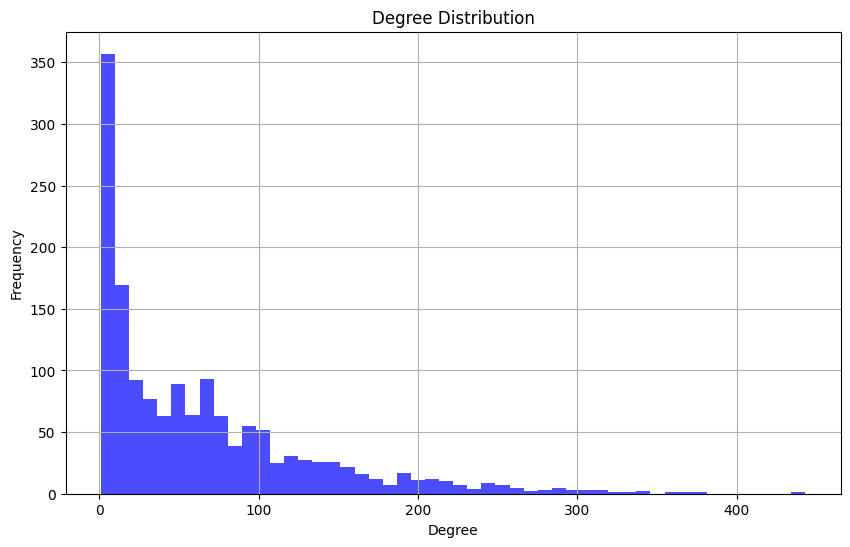

Average degree: 64.08718626155878
Maximum degree: 443
Minimum degree: 1


In [5]:
# Degree distribution
degrees = [G.degree(n) for n in G.nodes()]
degree_counts = nx.degree_histogram(G)

# Plot degree distribution
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50, color='blue', alpha=0.7)
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Print some statistics
print("Average degree:", sum(degrees) / len(degrees))
print("Maximum degree:", max(degrees))
print("Minimum degree:", min(degrees))


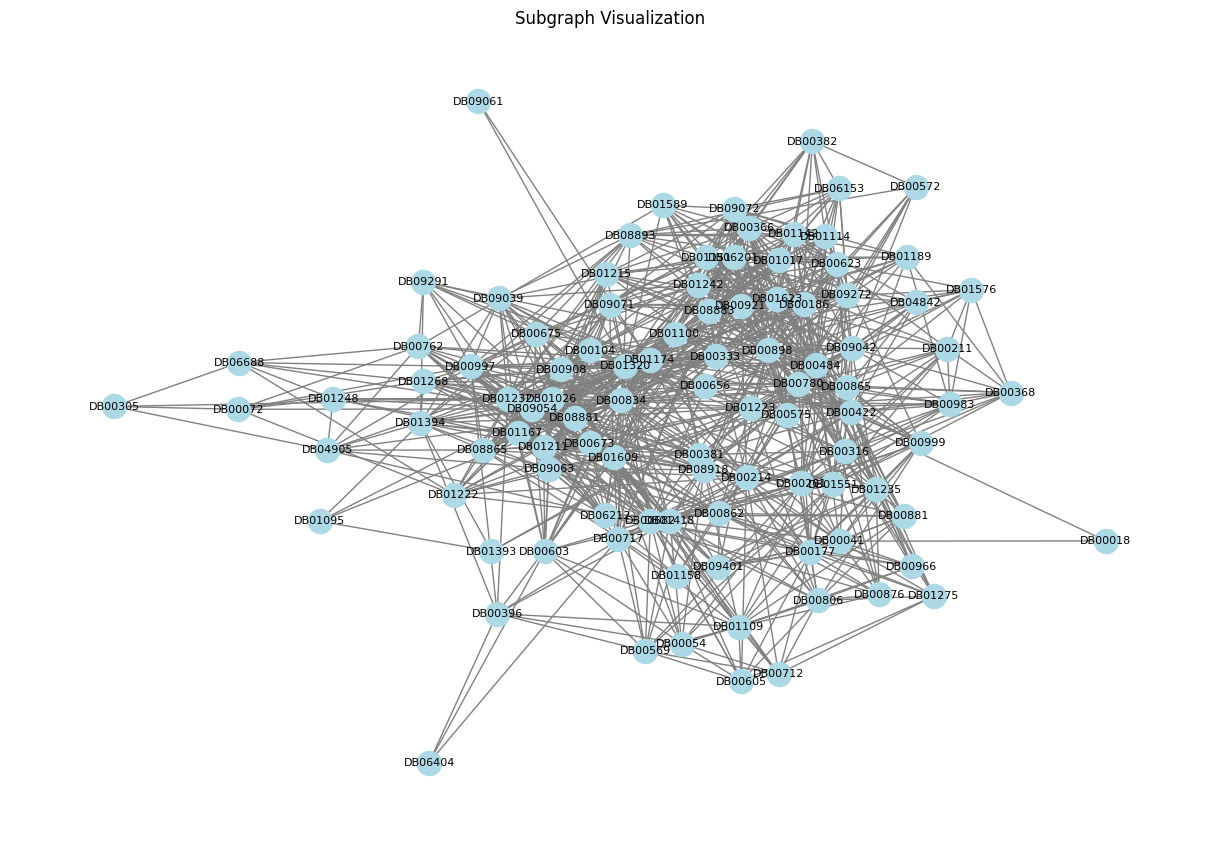

In [6]:
# Create a subgraph with the first 100 nodes for visualization
subgraph_nodes = list(G.nodes())[:100]
subgraph = G.subgraph(subgraph_nodes)

# Draw the subgraph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)  # Layout for positioning nodes
nx.draw(subgraph, pos, with_labels=True, node_size=300, node_color='lightblue', edge_color='gray', font_size=8)
plt.title('Subgraph Visualization')
plt.show()

## Graph centralities analysis

Centrality measures help identify the most influential or critical nodes in a network. In the context of drug-drug interactions:

- Degree Centrality: Highlights drugs that interact with the most other drugs, potentially indicating drugs with a high risk of causing adverse reactions.
- Betweenness Centrality: Identifies drugs that act as bridges between different groups of drugs, which could be critical in understanding how interactions propagate through the network.
- Closeness Centrality: Points to drugs that are closest to all other drugs in the network, suggesting they may have a broad influence on the overall system.
- Eigenvector Centrality: Reveals drugs that are connected to other highly influential drugs, indicating their importance in the network.

These measures can help identify drugs that are most likely to disrupt or disable others, providing valuable insights for drug safety and development.



In [7]:
# Function to print top 10 nodes for a centrality measure
def print_top_10(centrality, name):
    sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
    print(f"Top 10 nodes for {name}:")
    for node, value in sorted_centrality[:10]:
        print(f"Node: {node}, {name}: {value:.4f}")
    print()

# Function to plot centrality distribution
def plot_centrality_distribution(centrality, name):
    plt.figure(figsize=(10, 6))
    plt.hist(centrality.values(), bins=50, color='blue', alpha=0.7)
    plt.title(f'{name} Distribution')
    plt.xlabel(name)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

### Degree Centrality
Degree centrality is a measure that quantifies the importance of a node in a network based on the number of direct connections (edges) it has. In the context of your drug interaction network, a drug with high degree centrality interacts with many other drugs, suggesting that it may have a high potential for drug-drug interactions.

#### Mathematical Representation

Let $ G = (V, E) $ be an undirected graph where:

- $ V $ is the set of nodes (drugs)
- $ E $ is the set of edges (drug interactions)

The degree centrality $ C_D(v) $ of a node $ v $ is defined as:

$
C_D(v) = d(v) = \sum_{u \in V} A_{vu}
$

where $ A $ is the adjacency matrix, and $ A_{vu} = 1 $ if there is an edge between $ v $ and $ u $, otherwise $ A_{vu} = 0 $.


Top 10 nodes for Degree Centrality:
Node: DB00252, Degree Centrality: 0.2928
Node: DB00834, Degree Centrality: 0.2505
Node: DB00715, Degree Centrality: 0.2439
Node: DB00752, Degree Centrality: 0.2373
Node: DB00780, Degree Centrality: 0.2267
Node: DB00682, Degree Centrality: 0.2227
Node: DB01609, Degree Centrality: 0.2181
Node: DB00220, Degree Centrality: 0.2135
Node: DB00470, Degree Centrality: 0.2062
Node: DB00363, Degree Centrality: 0.2062



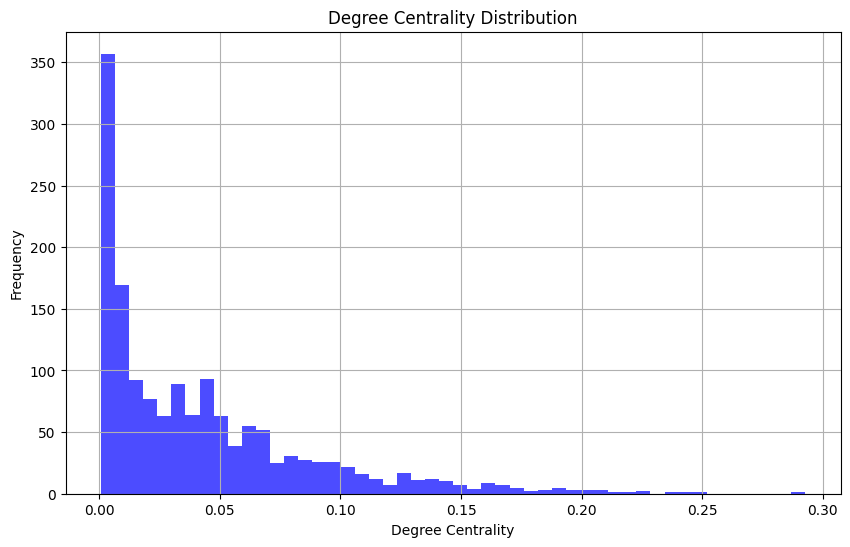

In [8]:
# 1. Degree Centrality
degree_centrality = nx.degree_centrality(G)
print_top_10(degree_centrality, "Degree Centrality")
plot_centrality_distribution(degree_centrality, "Degree Centrality")

### Eigenvector centrality
Eigenvector centrality measures a node’s importance while giving consideration to the importance of its neighbors. A high eigenvector score means that a node is connected to many nodes which themselves have high scores.

The eigenvector centrality $ c_{v_i} $ of $ v_i $ is the sum of the centralities of its neighbors:

$
c_{v_i} = \frac{1}{\lambda} \sum_{v_j \in \mathcal{N}_i} A_{ij} c_{v_j}
$

$
\mathbf{A} \mathbf{c} = \lambda \mathbf{c}
$


In a drug interaction network, eigenvector centrality can help identify key drugs that influence many others through highly connected pathways. Such drugs may be potential candidates for further study due to their impact on multiple interactions.

Top 10 nodes for Eigenvector Centrality:
Node: DB00252, Eigenvector Centrality: 0.1086
Node: DB00834, Eigenvector Centrality: 0.1044
Node: DB00956, Eigenvector Centrality: 0.0919
Node: DB01238, Eigenvector Centrality: 0.0916
Node: DB00715, Eigenvector Centrality: 0.0880
Node: DB00564, Eigenvector Centrality: 0.0878
Node: DB00503, Eigenvector Centrality: 0.0876
Node: DB00220, Eigenvector Centrality: 0.0873
Node: DB08912, Eigenvector Centrality: 0.0826
Node: DB01609, Eigenvector Centrality: 0.0826



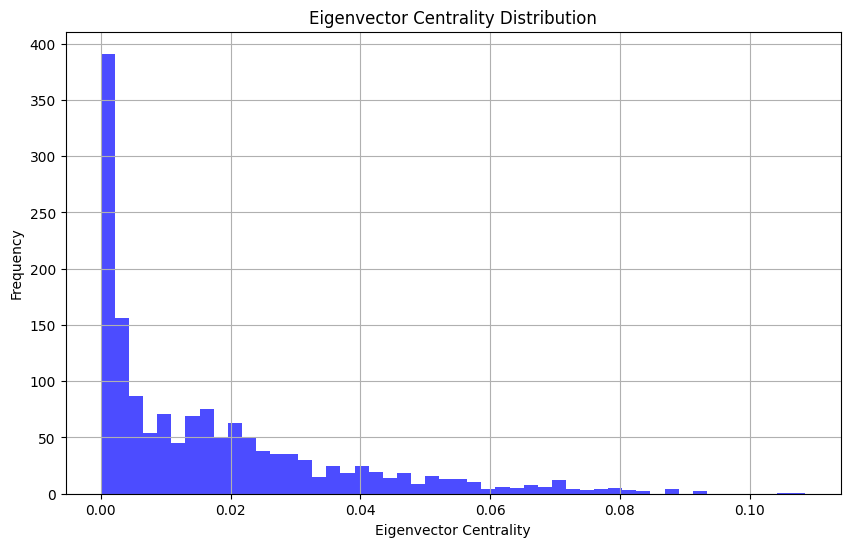

In [9]:
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
print_top_10(eigenvector_centrality, "Eigenvector Centrality")
plot_centrality_distribution(eigenvector_centrality, "Eigenvector Centrality")

### Katz Centrality
Katz centrality is a measure that extends eigenvector centrality by addressing its limitations in disconnected networks. It assigns importance to nodes based on both direct and indirect connections while ensuring that even isolated nodes have a nonzero centrality score.

#### Mathematical Representation

Let $ G = (V, E) $ be a directed or undirected graph with adjacency matrix $ A $. The Katz centrality $ c_v $ of node $ v $ is given by:

$
c_v = \alpha \sum_j A_{ij} c_j + \beta
$

where:

- $ \alpha $ is a damping factor $ 0 < \alpha < 1 $, ensuring convergence.
- $ \beta $ is a positive constant (usually 1), giving each node a minimum level of centrality.

In matrix form:

$
\mathbf{c} = \alpha A \mathbf{c} + \mathbf{1}
$

For the drug interaction network, it captures indirect interactions, making it more informative than degree centrality. However, careful parameter selection is needed to ensure meaningful results


Top 10 nodes for Katz Centrality:
Node: DB00834, Katz Centrality: 0.1198
Node: DB00252, Katz Centrality: 0.1174
Node: DB00956, Katz Centrality: 0.1072
Node: DB01238, Katz Centrality: 0.1047
Node: DB00220, Katz Centrality: 0.1025
Node: DB00503, Katz Centrality: 0.1015
Node: DB00564, Katz Centrality: 0.1011
Node: DB09118, Katz Centrality: 0.0994
Node: DB08912, Katz Centrality: 0.0971
Node: DB09054, Katz Centrality: 0.0960



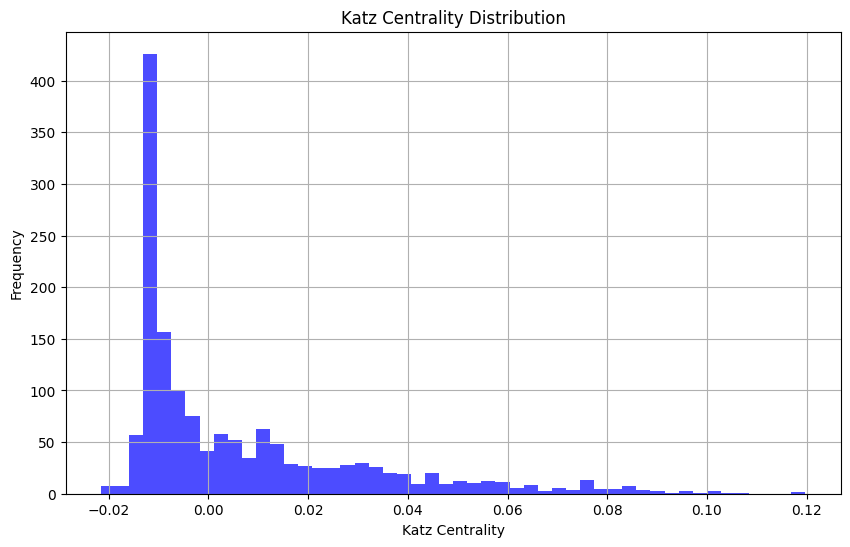

In [10]:
is_connected = nx.is_connected(G)
if not is_connected:
    katz_centrality = nx.katz_centrality_numpy(G, alpha=0.01, beta=1.0)
    print_top_10(katz_centrality, "Katz Centrality")
    plot_centrality_distribution(katz_centrality, "Katz Centrality")

### PageRank centrality

PageRank centrality is a variant of eigenvector centrality originally developed by Google to rank web pages. It measures the importance of a node based on the number and quality of incoming connections, distributing importance proportionally across its outgoing links.

#### Mathematical Representation
Given a directed graph $ G = (V, E) $, let $ d_i^+ $ be the out-degree of node $ v_i $. The transition probability matrix $ P $ is defined as:

$
P_{ij} =
\begin{cases} 
\frac{1}{d_i^+}, & \text{if } v_j \in \mathcal{N}_i^+ \\
0, & \text{otherwise}
\end{cases}
$

where $ \mathcal{N}_i^+ $ is the set of neighbors that receive links from $ v_i $. Since $ P $ is row stochastic, it satisfies:

$
\sum_j P_{ij} = 1
$

In matrix form, PageRank centrality $ \mathbf{c} $ satisfies:

$
\lambda \mathbf{c} = \mathbf{c} P \quad \text{with } \lambda = 1
$

which can be rewritten as:

$
\mathbf{c} = (D^+)^{-1} A
$

where $ D^+ $ is the diagonal matrix of out-degrees.


PageRank centrality is useful for identifying influential drugs in an interaction network, especially when directionality matters (i.e., one drug affects another but not vice versa), but in our case this is not applicable. It helps highlight drugs that are heavily affected by others, making it valuable for detecting drugs that could be highly sensitive to interactions. However, it assumes a probability-based flow of influence, which may not always align with biological mechanisms.


Top 10 nodes for PageRank Centrality:
Node: DB00682, PageRank Centrality: 0.0045
Node: DB00252, PageRank Centrality: 0.0041
Node: DB01418, PageRank Centrality: 0.0039
Node: DB00834, PageRank Centrality: 0.0033
Node: DB01609, PageRank Centrality: 0.0032
Node: DB00363, PageRank Centrality: 0.0032
Node: DB00715, PageRank Centrality: 0.0031
Node: DB00752, PageRank Centrality: 0.0031
Node: DB00864, PageRank Centrality: 0.0030
Node: DB00266, PageRank Centrality: 0.0029



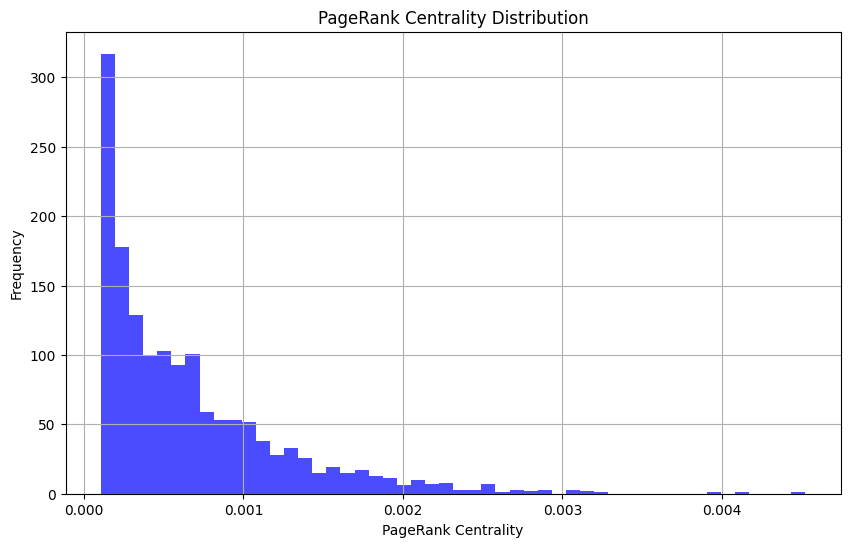

In [11]:
pagerank_centrality = nx.pagerank(G, alpha=0.85)
print_top_10(pagerank_centrality, "PageRank Centrality")
plot_centrality_distribution(pagerank_centrality, "PageRank Centrality")

## Clustering Coefficient Centrality

It measures how well the neighbors of a node are interconnected. It is defined as:

$
c_v = \frac{\text{Number of triangles involving } v}{\frac{1}{2} d_v (d_v - 1)}
$

where:
- $ d_v $ is the degree of node $ v $.
- The numerator counts the number of **triangles** (fully connected triplets) including $ v $.
- The denominator represents the **maximum possible** number of edges between neighbors of $ v $.

#### Interpretation:
- If $ c_v = 0 $, the neighbors of $ v $ are not connected.
- If $ c_v = 1 $, all neighbors of $ v $ are **fully interconnected**.


This centrality captures **local connectivity**, which may not be the most relevant for a our case. In this context:
- A high clustering coefficient means that a drug's interactions tend to form closed groups.
- A low clustering coefficient suggests that a drug interacts with drugs that are not strongly connected to each other.


While clustering may indicate drug families (highly interconnected groups of drugs with similar effects), it is not the best measure to identify the most influential drugs in terms of interactions.

In a drug interaction network, **fully connected subgroups** (e.g., drugs of a similar class that all interact with each other) lead to many nodes with \( c_v = 1 \).

Thus, if many drugs are grouped into **tightly connected clusters**, this measure will often reach its maximum value.

Top 10 nodes for Clustering Coefficient:
Node: DB01438, Clustering Coefficient: 1.0000
Node: DB01159, Clustering Coefficient: 1.0000
Node: DB00583, Clustering Coefficient: 1.0000
Node: DB00743, Clustering Coefficient: 1.0000
Node: DB04711, Clustering Coefficient: 1.0000
Node: DB00210, Clustering Coefficient: 1.0000
Node: DB09135, Clustering Coefficient: 1.0000
Node: DB06659, Clustering Coefficient: 1.0000
Node: DB01086, Clustering Coefficient: 1.0000
Node: DB01127, Clustering Coefficient: 1.0000



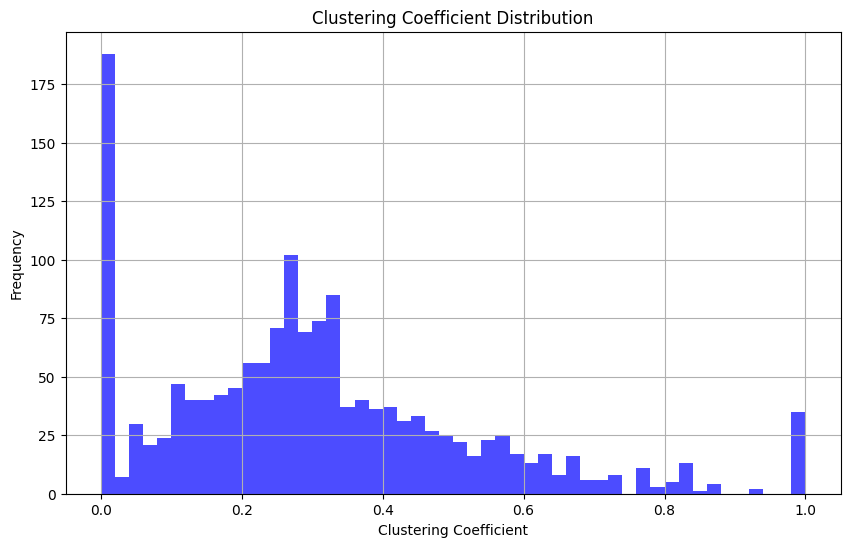

In [12]:
clustering_coefficient = nx.clustering(G)
print_top_10(clustering_coefficient, "Clustering Coefficient")
plot_centrality_distribution(clustering_coefficient, "Clustering Coefficient")

### Closeness Centrality

measures how quickly a node can reach all other nodes in the graph. It is defined as:

$
C_C(v) = \frac{1}{\sum_{u \neq v} d(v, u)}
$

where:
- $ d(v, u) $ is the shortest path distance between node $ v $ and node $ u $.
- A **higher** closeness centrality means a node is **more central**, as it has shorter paths to all other nodes.

With that in mind,
- **Nodes with high closeness** are **well-positioned** to quickly reach all other nodes.
- **Nodes with low closeness** are in the **periphery** of the network, meaning they take longer to connect to others.

In the drug context, closeness centrality identifies drugs that are **central in the interaction web**, meaning:
- They **interact with many other drugs** (directly or indirectly).
- They **serve as bridges** in drug interaction pathways.

This is useful because:
- **Drugs with high closeness** may have **greater interaction potential**, meaning they could be **high-risk** for unexpected side effects.
- **Drugs with low closeness** may be **specialized** or **isolated** in their interactions.

Why Some Nodes Have Low Closeness?
- If the graph has **many disconnected components**, nodes in **small subgraphs** will have low closeness.
- Nodes in **highly clustered regions** might also have lower closeness since they are far from the **global** center of the graph.

Top 10 nodes for Closeness Centrality:
Node: DB00252, Closeness Centrality: 0.5545
Node: DB00834, Closeness Centrality: 0.5402
Node: DB01609, Closeness Centrality: 0.5260
Node: DB00794, Closeness Centrality: 0.5249
Node: DB00220, Closeness Centrality: 0.5237
Node: DB00715, Closeness Centrality: 0.5228
Node: DB00682, Closeness Centrality: 0.5222
Node: DB01320, Closeness Centrality: 0.5209
Node: DB00503, Closeness Centrality: 0.5200
Node: DB00564, Closeness Centrality: 0.5193



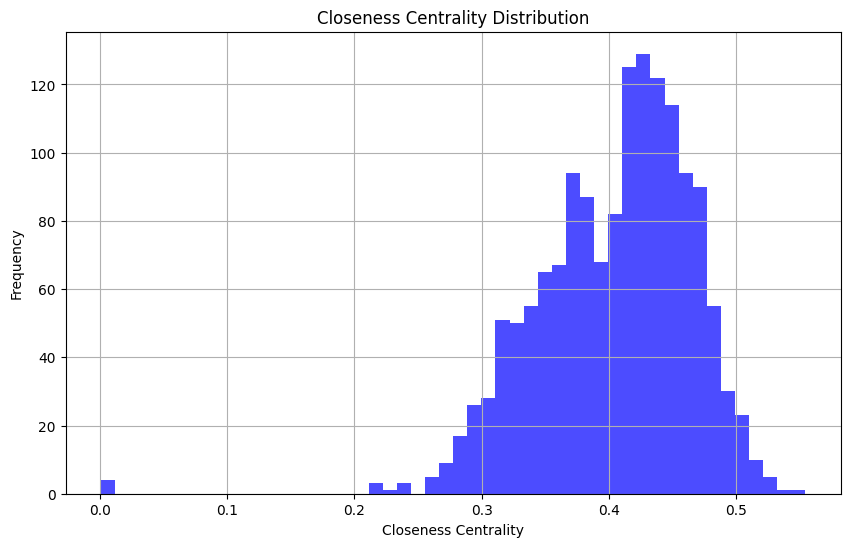

In [13]:
closeness_centrality = nx.closeness_centrality(G)
print_top_10(closeness_centrality, "Closeness Centrality")
plot_centrality_distribution(closeness_centrality, "Closeness Centrality")


### Betweenness Centrality

It measures how often a node appears on the shortest paths between other nodes. It is defined as:

$
C_B(v) = \sum_{s \neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}
$

where:
- $ \sigma_{st} $ is the total number of shortest paths between nodes $ s $ and $ t $.
- $ \sigma_{st}(v) $ is the number of those shortest paths that pass through node $ v $.
- A **higher** betweenness centrality means a node is **critical for connectivity** in the graph.

#### Interpretation
- **Nodes with high betweenness** act as **bridges** between different parts of the network.
- **Nodes with low betweenness** are in densely connected areas where multiple alternative paths exist.


In a **drug interaction network**, betweenness centrality helps identify:
- **Key drugs** that connect different drug groups or clusters.
- **Potential "hub" drugs** that, if removed, could **disrupt** the interaction network.
- **Drugs with a high risk of cascading effects**, since they mediate interactions between multiple drug families.

This is **particularly useful** for:
- Identifying **critical drugs** that, when combined with others, might cause severe side effects.
- Understanding **which drugs influence multiple pharmacological pathways**.

#### Why Some Nodes Have Low Betweenness?
- **Peripheral nodes** that are not on many shortest paths will have low betweenness.
- **Nodes inside tightly connected clusters** will also have low betweenness since many alternative paths exist within the cluster.

In conclusion, it identifies drugs that act as **key intermediaries** in interactions. Drugs with high betweenness may be **high-risk candidates** for interactions and should be carefully monitored.

Top 10 nodes for Betweenness Centrality:
Node: DB00682, Betweenness Centrality: 0.0420
Node: DB01418, Betweenness Centrality: 0.0290
Node: DB00252, Betweenness Centrality: 0.0284
Node: DB00363, Betweenness Centrality: 0.0276
Node: DB00864, Betweenness Centrality: 0.0206
Node: DB01609, Betweenness Centrality: 0.0199
Node: DB00266, Betweenness Centrality: 0.0186
Node: DB00091, Betweenness Centrality: 0.0178
Node: DB00715, Betweenness Centrality: 0.0168
Node: DB09268, Betweenness Centrality: 0.0165



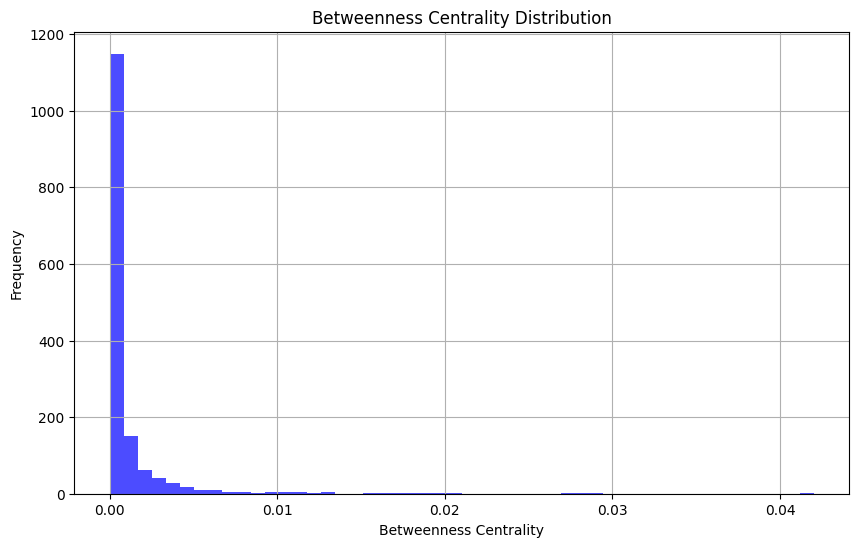

In [14]:
betweenness_centrality = nx.betweenness_centrality(G)
print_top_10(betweenness_centrality, "Betweenness Centrality")
plot_centrality_distribution(betweenness_centrality, "Betweenness Centrality")

## Conclusions

In [16]:
# Borda Count to determine the most central node
def borda_count(centralities):
    borda_scores = {}
    for centrality in centralities:
        sorted_nodes = sorted(centrality.keys(), key=lambda x: centrality[x], reverse=True)
        for rank, node in enumerate(sorted_nodes):
            if node not in borda_scores:
                borda_scores[node] = 0
            borda_scores[node] += len(sorted_nodes) - rank
    return borda_scores

# List of all centrality measures
centralities = [
    degree_centrality,
    eigenvector_centrality,
    katz_centrality,
    pagerank_centrality,
    # clustering_coefficient,  # removed because of many nodes with maximum value
    closeness_centrality,
    betweenness_centrality
]

# Compute Borda count
borda_scores = borda_count(centralities)
sorted_borda = sorted(borda_scores.items(), key=lambda x: x[1], reverse=True)

# Print top 10 nodes based on Borda count
print("Top 10 nodes based on Borda count:")
for node, score in sorted_borda[:10]:
    print(f"Node: {node}, Borda Score: {score}")


Top 10 nodes based on Borda count:
Node: DB00252, Borda Score: 9080
Node: DB00834, Borda Score: 9068
Node: DB01609, Borda Score: 9038
Node: DB00715, Borda Score: 9022
Node: DB00220, Borda Score: 9004
Node: DB00503, Borda Score: 9001
Node: DB01320, Borda Score: 9000
Node: DB01238, Borda Score: 8999
Node: DB00564, Borda Score: 8991
Node: DB00956, Borda Score: 8986


# Community detection Analysis

In [21]:
# Function to print community statistics
def print_community_stats(communities):
    print(f"Number of communities: {len(communities)}")
    sizes = [len(comm) for comm in communities]
    print(f"Community sizes: {sizes}")
    print(f"Largest community: {max(sizes)}")
    print(f"Smallest community: {min(sizes)}")
    print(f"Average community size: {np.mean(sizes):.2f}")
    print()

# Function to plot communities
def plot_aggregated_communities(G, communities, title):
    # Create a new graph where each node represents a community
    community_graph = nx.Graph()
    for i, comm in enumerate(communities):
        community_graph.add_node(i, size=len(comm))  # Store community size as a node attribute
        for node in comm:
            for neighbor in G.neighbors(node):
                for j, other_comm in enumerate(communities):
                    if neighbor in other_comm and i != j:
                        if community_graph.has_edge(i, j):
                            community_graph[i][j]['weight'] += 1
                        else:
                            community_graph.add_edge(i, j, weight=1)

    # Plot the aggregated community graph
    fig, ax = plt.subplots(figsize=(12, 8))
    pos = nx.spring_layout(community_graph, seed=42, k=10.0)

    # Extract edge weights for color mapping
    edge_weights = [community_graph[i][j]['weight'] for i, j in community_graph.edges()]
    edge_colors = edge_weights  # Use edge weights directly for color mapping

    # Normalize edge weights for the color map
    norm = Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
    cmap = plt.get_cmap('viridis')  # Choose a colormap

    # Draw nodes with fixed size and labels for community sizes
    nx.draw_networkx_nodes(community_graph, pos, node_size=300, node_color='lightblue', alpha=0.8, ax=ax)
    for node, (x, y) in pos.items():
        ax.text(x, y + 0.05, s=f"{community_graph.nodes[node]['size']}", 
                fontsize=10, ha='center', va='center', color='black')

    # Draw edges with color based on weight
    edges = nx.draw_networkx_edges(community_graph, pos, edge_color=edge_colors, 
                                   width=2, alpha=0.6, edge_cmap=cmap, edge_vmin=min(edge_weights), 
                                   edge_vmax=max(edge_weights), ax=ax)

    # Add a color bar for edge weights
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Edge Weight (Number of Connections)', shrink=0.8)

    # Add labels for nodes (optional, can be disabled if too cluttered)
    nx.draw_networkx_labels(community_graph, pos, font_size=8, font_color='black', ax=ax)

    plt.title(title)
    plt.show()


Louvain Communities:
Number of communities: 9
Community sizes: [154, 215, 199, 331, 425, 181, 5, 2, 2]
Largest community: 425
Smallest community: 2
Average community size: 168.22



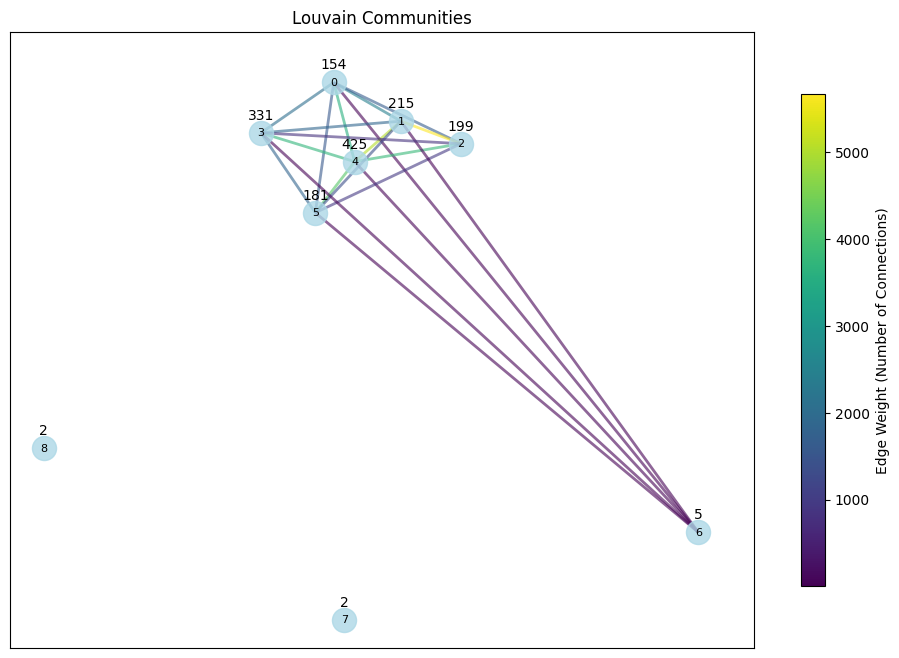

In [29]:
# 2. Modularity maximization (Louvain Algorithm)
def louvain_communities(G):
    partition = community_louvain.best_partition(G)
    communities = defaultdict(list)
    for node, comm_id in partition.items():
        communities[comm_id].append(node)
    return list(communities.values())

print("Louvain Communities:")
louvain_communities = louvain_communities(G)
print_community_stats(louvain_communities)
plot_aggregated_communities(G, louvain_communities, "Louvain Communities")


Hierarchical Clustering Communities:


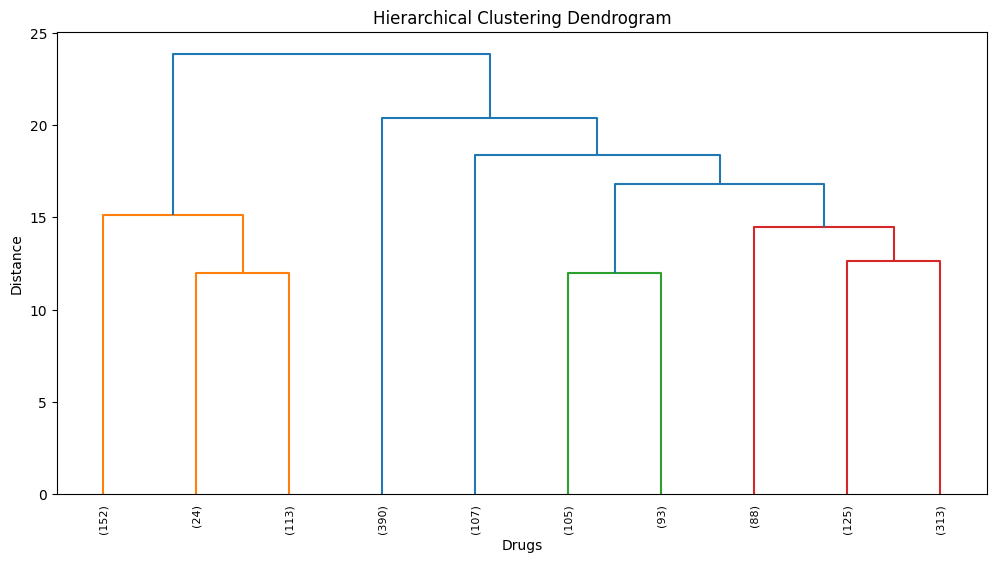

Number of communities: 156
Community sizes: [16, 20, 35, 57, 9, 14, 21, 24, 15, 28, 5, 20, 40, 29, 11, 4, 46, 15, 9, 16, 26, 17, 18, 20, 10, 17, 8, 16, 7, 16, 26, 37, 7, 3, 25, 14, 7, 24, 5, 11, 8, 8, 8, 10, 13, 7, 4, 17, 10, 13, 5, 5, 4, 4, 9, 10, 6, 14, 13, 15, 6, 13, 10, 13, 13, 5, 16, 12, 9, 10, 9, 6, 6, 10, 17, 9, 5, 16, 7, 6, 3, 10, 6, 12, 10, 4, 6, 4, 9, 3, 4, 3, 10, 14, 3, 7, 5, 6, 5, 7, 5, 5, 7, 6, 5, 5, 4, 4, 4, 30, 4, 6, 8, 6, 12, 5, 3, 5, 4, 6, 2, 5, 3, 4, 3, 5, 3, 4, 3, 6, 4, 2, 2, 3, 5, 3, 2, 2, 3, 2, 3, 3, 5, 4, 2, 2, 2, 4, 3, 4, 6, 2, 5, 2, 2, 1]
Largest community: 57
Smallest community: 1
Average community size: 9.68



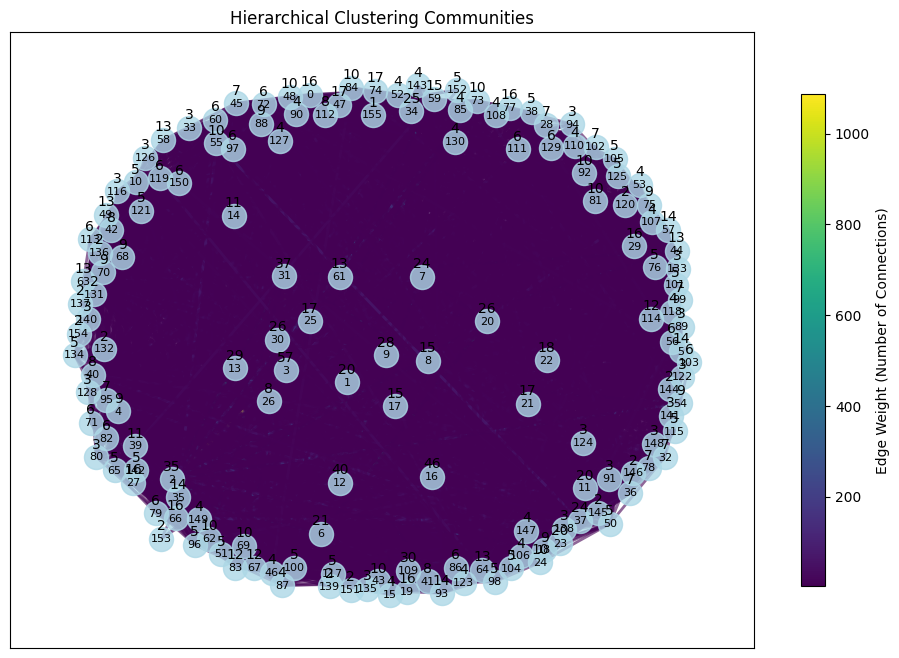

In [34]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Step 1: Compute the distance matrix (using shortest path length)
def compute_distance_matrix(G):
    # Compute the shortest path lengths between all pairs of nodes
    shortest_paths = dict(nx.shortest_path_length(G))
    distance_matrix = np.zeros((len(G), len(G)))
    nodes = list(G.nodes())
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if v in shortest_paths[u]:
                distance_matrix[i, j] = shortest_paths[u][v]
            else:
                # Replace infinite distances with a large finite value (e.g., diameter + 1)
                distance_matrix[i, j] = nx.diameter(G) + 1
    return distance_matrix, nodes

# Step 2: Perform hierarchical clustering
def hierarchical_clustering(G, threshold=3):
    # Ensure the graph is connected by using the largest connected component (LCC)
    G = G.subgraph(max(nx.connected_components(G), key=len))
    
    # Compute the distance matrix
    distance_matrix, nodes = compute_distance_matrix(G)
    
    # Convert to condensed form
    condensed_distance = squareform(distance_matrix)
    
    # Perform hierarchical clustering
    Z = linkage(condensed_distance, method='ward')  # Use Ward's method for clustering

    # Step 3: Plot the dendrogram (limit the number of leaf nodes for readability)
    plt.figure(figsize=(12, 6))
    dendrogram(Z, labels=nodes, leaf_rotation=90, leaf_font_size=8, p=10, truncate_mode='lastp')  # Show only the last 10 merged clusters
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Drugs')
    plt.ylabel('Distance')
    plt.show()

    # Step 4: Extract communities by cutting the dendrogram
    communities = fcluster(Z, t=threshold, criterion='distance')
    community_dict = defaultdict(list)
    for node, comm_id in zip(nodes, communities):
        community_dict[comm_id].append(node)
    return list(community_dict.values())

# Run hierarchical clustering
print("Hierarchical Clustering Communities:")
hierarchical_communities = hierarchical_clustering(G, threshold=3)
print_community_stats(hierarchical_communities)
plot_aggregated_communities(G, hierarchical_communities, "Hierarchical Clustering Communities")


In [32]:
from networkx.algorithms.community import girvan_newman

sla= girvan_newman(G)
tuple(sorted(c) for c in next(sla))


KeyboardInterrupt: 

In [ ]:
# Compare communities using modularity
def compare_modularity(G, communities):
    modularity = nx.algorithms.community.modularity(G, communities)
    print(f"Modularity: {modularity:.4f}")

print("Modularity Comparison:")
print("Louvain Communities:")
compare_modularity(G, louvain_communities)
print("Walktrap Communities:")
compare_modularity(G, walktrap_communities)
